In [1]:
# Import all dependencies
import pyshred
from pyshred import *
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Including Landlab dependencies
from landlab.plot import imshow_grid
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder, LinearDiffuser, PerronNLDiffuse, TaylorNonLinearDiffuser
from matplotlib.pyplot import figure, show, plot, xlabel, ylabel, title

data = []
# data stores an entire elevation map for every index, where indices are timesteps in years

c:\myapps\Anaconda\envs\shred-ll-env\lib\site-packages\pysindy\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


c:\myapps\Anaconda\envs\shred-ll-env\lib\site-packages\landlab\field\graph_field.py:1347: FutureWarning: Calling `add_empty` with the field location as the first argument is deprecated and will be removed in future versions. Instead, please use the `at` keyword to specify the location: add_empty(arg0, at='node').
  data = self.add_empty(*args, **kwds)


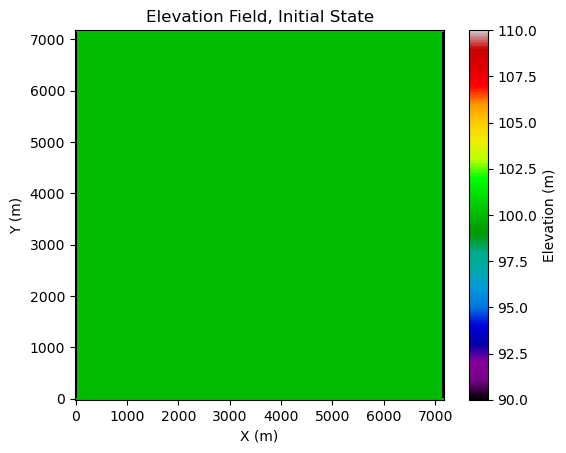

In [2]:
# The grid is 200 rows by 150 columns, with dx = dy = 50 m.
cell_width_length = 40
rows = 180
columns = 180

mg = RasterModelGrid((rows, columns), cell_width_length) 

mg.set_closed_boundaries_at_grid_edges(
    right_is_closed=True,
    top_is_closed=False,
    left_is_closed=True,
    bottom_is_closed=False
)

# Create an initial elevation field with some random perturbations.
# Elevation will be, by default 100 m not 0.
z = 100 + mg.add_zeros('node', 'topographic__elevation')

# Add roughness
initial_roughness = np.random.rand(mg.core_nodes.size) / 5

# Add roughness to the elevation field
mg.at_node['topographic__elevation'][mg.core_nodes] += initial_roughness

imshow_grid(mg, z, grid_units=['m','m'], plot_name="Elevation Field, Initial State", var_name='Elevation (m)', cmap='nipy_spectral')  

In [3]:
# total_t = 5000000. # this is how long we will run the model for
total_t = 5000000
dt = 1000 # time step in years over which cumulative erosion is calculated and applied to each cell to speed up the model we can use long time scales when hydrology is steady-state in a year. t
nt = int(total_t // dt) # number of time steps


# used for SHRED later, we set a "lags", trying to capture a reasonable time window where
# change occurs -> not too small so that no change is captured, not so large that nothing is
# captured.
reasonable_lag = 20

uplift_rate = 0.0004 # uplift rate, this can be a lot hire when landslides are considered
uplift_per_step = uplift_rate * dt # depth (m) of uplift per timestep

Mean_elev=[] # an array to hold the mean elevation of the modeled domain

In [4]:
# Choose diffusivity value and instantiate objects for hillslope diffusion and assign parameter values

# Option 1: LinearDiffuser
k_d = 0.01  # m2/y this is a high-end for this parameter
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=k_d, deposit=True)

# Option 2: Non-linear Diffusion
k_d_nonlin=0.01    # 0.01-0.03   for Oregon like forest, first number with fires second w/o
Sc=1.125           # 1-1.25      for Oregon like forest, first number with fires second w/o
Taylor_nonlin_diffuse = TaylorNonLinearDiffuser(mg, linear_diffusivity=k_d_nonlin, slope_crit=Sc, if_unstable='warn')

# NOTE that if deposit=True, the slope area data will look different.

In [5]:
# Instantiate an object of the FlowAccumulator
fr = FlowAccumulator(mg, flow_director='FlowDirectorD8') 

# Choose parameter values for the stream power (SP) equation
# and instantiate an object of the FastscapeEroder
K_sp=0.00001 # erodibility in SP eqtn, units depend on m_sp (0.00001 for m=0.5) (0.00005 for m=0.25)
m_sp=0.5 # exponent on drainage area in SP eqtn
n_sp=1 # exponent on slope in the SP eqtn

sp = FastscapeEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0)

In [6]:
# Start with three sensors
land_sensors = 3
time_count = nt

temporal_elevation = np.zeros((land_sensors, time_count))

temporal_elevation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
elevation_snapshots = np.ndarray(shape=(nt, mg.at_node['topographic__elevation'][mg.core_nodes].shape[0]))
for i in range(nt):
    lin_diffuse.run_one_step(dt) # linear diffusion
    fr.run_one_step() # route flow
    sp.run_one_step(dt) # fluvial (SP) incision
    
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step # add the uplift
    Mean_elev.append(np.mean(mg.at_node['topographic__elevation'][mg.core_nodes]))
    elevation_snapshots[i] = mg.at_node['topographic__elevation'][mg.core_nodes]
    # Let's choose node 50, 100, and 150 for example
    temporal_elevation[0][i]=mg.at_node['topographic__elevation'][mg.core_nodes][100]
    temporal_elevation[1][i]=mg.at_node['topographic__elevation'][mg.core_nodes][300]
    temporal_elevation[2][i]=mg.at_node['topographic__elevation'][mg.core_nodes][400]
    
    if i % 500 == 0: 
      print ("Completed loop", i, "out of", nt)

# Now elevation_snapshots stores a full spatiotemporal dataset of our full states:
print(f"elevation_snapshots dims: {elevation_snapshots.shape}")

Completed loop 0 out of 5000
Completed loop 500 out of 5000
Completed loop 1000 out of 5000
Completed loop 1500 out of 5000
Completed loop 2000 out of 5000
Completed loop 2500 out of 5000
Completed loop 3000 out of 5000
Completed loop 3500 out of 5000
Completed loop 4000 out of 5000
Completed loop 4500 out of 5000
elevation_snapshots dims: (5000, 31684)


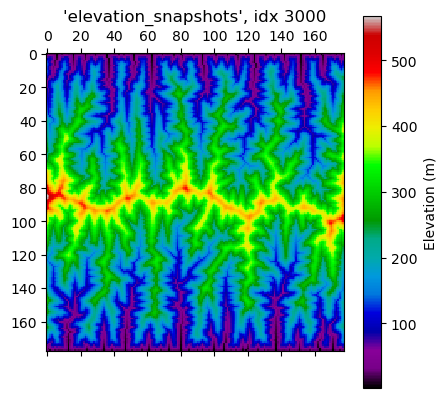

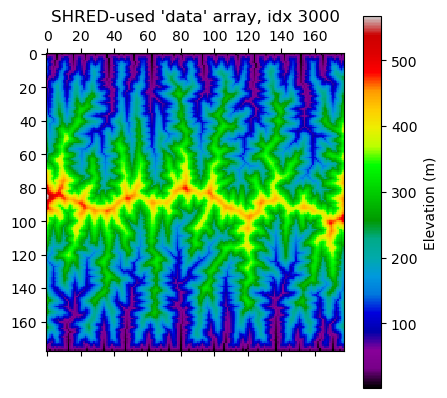

In [8]:
# Transfer all data from elevation_snapshots to the "data" variable, used later for SHRED
plt.matshow(np.reshape(elevation_snapshots[3000], (178, 178)), cmap="nipy_spectral")
plt.title("'elevation_snapshots', idx 3000")
plt.colorbar(label="Elevation (m)")

data = np.ndarray(shape=(nt, 178, 178))
for i in range(elevation_snapshots.shape[0]):
    data[i] = np.reshape(elevation_snapshots[i], (178, 178))

plt.matshow(data[3000], cmap="nipy_spectral")
plt.title("SHRED-used 'data' array, idx 3000")
plt.colorbar(label="Elevation (m)")

Evaluates the MSE of the reconstruction (nowcast) and forecasting errors (as in the future states) by random selection of the sensors, iterating in a loop of selecting 5, 10, 50, 100, 500 sensors just to have a systematic/quantitative measurement of the performance improvement of (at least) the reconstruction as a function of input/latent space size.

In [15]:
import random
random_range = (40, 150)
full_sensor_size = 500
# Init 500 random sensor locations
x_sensors = np.ndarray(shape=(full_sensor_size))
y_sensors = np.ndarray(shape=(full_sensor_size))

for i in range(full_sensor_size):
    x_sensors[i] = random.randint(random_range[0], random_range[1])
    y_sensors[i] = random.randint(random_range[0], random_range[1])

full_sensors = [(int(x), int(y)) for x, y in zip(x_sensors, y_sensors)]

Full range:  [(64, 95), (128, 82), (81, 74), (67, 112), (64, 82)]
Fitting SHRED...
MSE with 5 sensors: 0.0027889747036901513
y_true:  (1000, 178, 178)
y_pred:  (1000, 178, 178)
MSE of entire validation dataset:  260.7215323750042


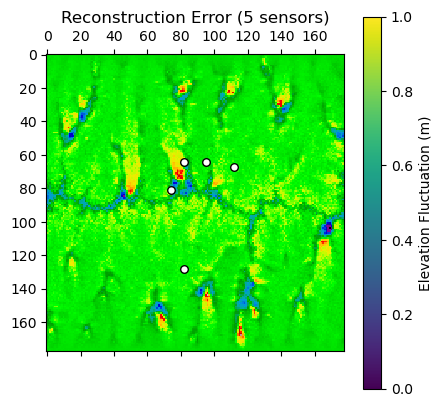

Full range:  [(64, 95), (128, 82), (81, 74), (67, 112), (64, 82), (147, 64), (138, 62), (144, 106), (100, 124), (100, 121)]
Fitting SHRED...
MSE with 10 sensors: 0.0029293329628741044
y_true:  (1000, 178, 178)
y_pred:  (1000, 178, 178)
MSE of entire validation dataset:  277.0306037611761


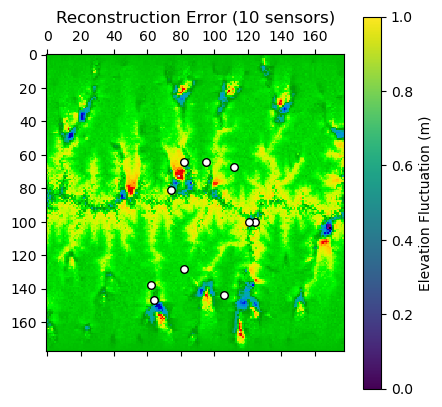

Full range:  [(64, 95), (128, 82), (81, 74), (67, 112), (64, 82), (147, 64), (138, 62), (144, 106), (100, 124), (100, 121), (51, 81), (87, 126), (147, 104), (103, 139), (127, 70), (125, 79), (128, 64), (145, 119), (118, 119), (146, 107), (64, 83), (142, 66), (105, 57), (131, 65), (129, 149), (46, 54), (95, 126), (140, 81), (103, 60), (77, 87), (121, 72), (78, 136), (52, 73), (44, 108), (59, 78), (100, 89), (110, 97), (150, 42), (102, 112), (85, 42), (60, 130), (95, 82), (52, 141), (61, 133), (60, 103), (42, 92), (87, 78), (70, 45), (68, 103), (74, 78)]
Fitting SHRED...
MSE with 50 sensors: 0.0037969307877201426
y_true:  (1000, 178, 178)
y_pred:  (1000, 178, 178)
MSE of entire validation dataset:  305.7740103549839


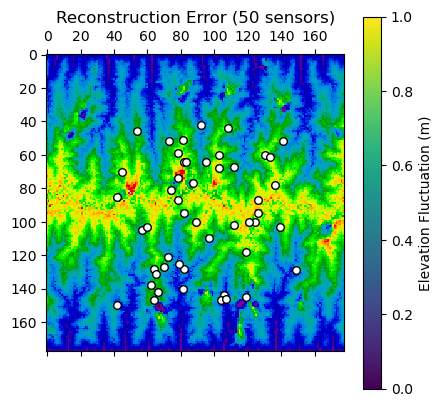

Full range:  [(64, 95), (128, 82), (81, 74), (67, 112), (64, 82), (147, 64), (138, 62), (144, 106), (100, 124), (100, 121), (51, 81), (87, 126), (147, 104), (103, 139), (127, 70), (125, 79), (128, 64), (145, 119), (118, 119), (146, 107), (64, 83), (142, 66), (105, 57), (131, 65), (129, 149), (46, 54), (95, 126), (140, 81), (103, 60), (77, 87), (121, 72), (78, 136), (52, 73), (44, 108), (59, 78), (100, 89), (110, 97), (150, 42), (102, 112), (85, 42), (60, 130), (95, 82), (52, 141), (61, 133), (60, 103), (42, 92), (87, 78), (70, 45), (68, 103), (74, 78), (51, 91), (86, 76), (51, 77), (91, 139), (59, 141), (57, 132), (79, 97), (130, 122), (53, 47), (40, 130), (129, 134), (59, 71), (147, 139), (144, 137), (111, 76), (143, 135), (103, 141), (141, 113), (62, 84), (59, 114), (72, 145), (76, 61), (49, 100), (147, 125), (41, 71), (78, 59), (107, 46), (137, 69), (137, 68), (146, 116), (93, 93), (101, 114), (85, 65), (110, 74), (143, 126), (81, 124), (109, 44), (86, 119), (46, 42), (104, 50), (11

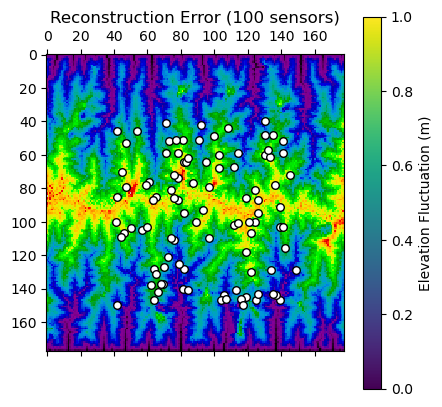

Full range:  [(64, 95), (128, 82), (81, 74), (67, 112), (64, 82), (147, 64), (138, 62), (144, 106), (100, 124), (100, 121), (51, 81), (87, 126), (147, 104), (103, 139), (127, 70), (125, 79), (128, 64), (145, 119), (118, 119), (146, 107), (64, 83), (142, 66), (105, 57), (131, 65), (129, 149), (46, 54), (95, 126), (140, 81), (103, 60), (77, 87), (121, 72), (78, 136), (52, 73), (44, 108), (59, 78), (100, 89), (110, 97), (150, 42), (102, 112), (85, 42), (60, 130), (95, 82), (52, 141), (61, 133), (60, 103), (42, 92), (87, 78), (70, 45), (68, 103), (74, 78), (51, 91), (86, 76), (51, 77), (91, 139), (59, 141), (57, 132), (79, 97), (130, 122), (53, 47), (40, 130), (129, 134), (59, 71), (147, 139), (144, 137), (111, 76), (143, 135), (103, 141), (141, 113), (62, 84), (59, 114), (72, 145), (76, 61), (49, 100), (147, 125), (41, 71), (78, 59), (107, 46), (137, 69), (137, 68), (146, 116), (93, 93), (101, 114), (85, 65), (110, 74), (143, 126), (81, 124), (109, 44), (86, 119), (46, 42), (104, 50), (11

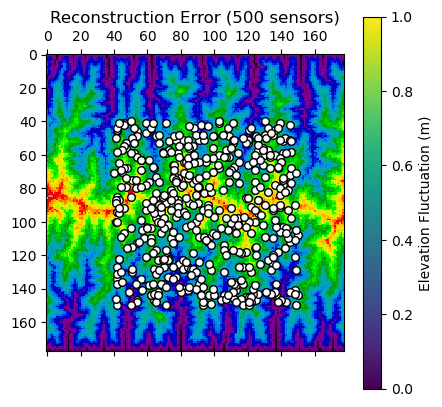

In [16]:
from re import M
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make a list of sensor sampling sizes to test
sensor_sampling_sizes = [5, 10, 50, 100, 500]

# Go through and calculate what the MSE between nowcasts and ground truths are 
# for each sensor sampling size.
for i in range(len(sensor_sampling_sizes)):
    print("Full range: ", full_sensors[0:sensor_sampling_sizes[i]])
    manager = DataManager(
        lags=reasonable_lag,
        train_size=0.7,
        val_size=0.2,
        test_size=0.1,
    )

    manager.add_data(
        data=data,
        id="elevation_data",
        stationary=full_sensors[0:sensor_sampling_sizes[i]],
        compress=False
    )

    training_data, val_data, testing_data = manager.prepare()

    shredModel = SHRED(
        sequence_model="LSTM",
        decoder_model="MLP",
        latent_forecaster="LSTM_Forecaster"
    )

    shredModel.fit(
        train_dataset=training_data,
        val_dataset=val_data,
        num_epochs=2,
        verbose=False
    )

    shredTestEval = shredModel.evaluate(dataset=val_data)
    print(f"MSE with {sensor_sampling_sizes[i]} sensors: {shredTestEval}")

    mappingEngine = SHREDEngine(
        manager,
        shredModel
    )

    validation_latents = mappingEngine.sensor_to_latent(manager.val_sensor_measurements)
    reconstructed_map = mappingEngine.decode(mappingEngine.sensor_to_latent(manager.val_sensor_measurements))

    n_train = int(0.7 * data.shape[0])
    lags = reasonable_lag

    recon_idx = 0
    global_idx = n_train + lags + recon_idx

    latents = mappingEngine.sensor_to_latent(manager.val_sensor_measurements)
    recon_dict = mappingEngine.decode(latents)   # dict[id] -> (T, *spatial_shape)
    
    truth_map = data[global_idx]
    nowcast = reconstructed_map['elevation_data'][recon_idx]

    records = []
    id = "elevation_data"
    y_true = data[manager.val_indices]
    y_pred = recon_dict[id]

    print("y_true: ", y_true.shape)
    print("y_pred: ", y_pred.shape)
    y_true_flat = y_true.reshape(y_true.shape[0], -1)
    y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)

    mse = mean_squared_error(y_true_flat, y_pred_flat)

    print("MSE of entire validation dataset: ", mse)
    
    current_sensors = full_sensors[0:sensor_sampling_sizes[i]]
    sensor_rows = [s[0] for s in current_sensors]
    sensor_cols = [s[1] for s in current_sensors]
    
    plt.matshow(truth_map - reconstructed_map["elevation_data"][recon_idx], cmap="nipy_spectral")
    plt.scatter(sensor_cols, sensor_rows, c='white', edgecolors='black', s=30, marker='o')
    plt.title(f"Reconstruction Error ({sensor_sampling_sizes[i]} sensors)")
    plt.colorbar(label="Elevation Fluctuation (m)")
    plt.show()
